# Estimation of tree height using GEDI dataset - Support Vector Machine for Regression (SVR) - 2024

Let's see a quick example of how to use Suppor Vector Regression for tree height estimation

    cd /media/sf_LVM_shared/my_SE_data/exercise
    source $HOME/venv/bin/activate
    python -m ipykernel install --user --name=venv
    jupyter lab Tree_Height_04SVM_pred_2024.ipynb

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
import scipy

# For visualization
import rasterio
from rasterio import *
from rasterio.plot import show
from pyspatialml import Raster
from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split,GridSearchCV
# from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

We will load the data using Pandas and display few samples of it

In [31]:
# data = pd.read_csv("./tree_height_2/txt/eu_x_y_height_predictors_select.txt", sep=" ",  index_col=False)
# pd.set_option('display.max_columns',None)

# print(data.shape)
# data.head(10)
predictors = pd.read_csv("./tree_height_2/txt/eu_x_y_height_predictors_select.txt", sep=" ",  index_col=False)
pd.set_option('display.max_columns',None)
# change column name
predictors = predictors.rename({'dev-magnitude':'devmagnitude'} , axis='columns')
predictors.head(10)

,ID,X,Y,h,BLDFIE_WeigAver,CECSOL_WeigAver,CHELSA_bio18,CHELSA_bio4,convergence,cti,devmagnitude,eastness,elev,forestheight,glad_ard_SVVI_max,glad_ard_SVVI_med,glad_ard_SVVI_min,northness,ORCDRC_WeigAver,outlet_dist_dw_basin,SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover
0,1,6.050001,49.727499,3139.00,1540,13,2113,5893,-10.486560,-238043120,1.158417,0.069094,353.983124,23,276.871094,46.444092,347.665405,0.042500,9,780403,19.798992,440.672211,85
1,2,6.050002,49.922155,1454.75,1491,12,1993,5912,33.274361,-208915344,-1.755341,0.269112,267.511688,19,-49.526367,19.552734,-130.541748,0.182780,16,772777,20.889412,457.756195,85
2,3,6.050002,48.602377,853.50,1521,17,2124,5983,0.045293,-137479792,1.908780,-0.016055,389.751160,21,93.257324,50.743652,384.522461,0.036253,14,898820,20.695877,481.879700,62
3,4,6.050009,48.151979,3141.00,1526,16,2569,6130,-33.654274,-267223072,0.965787,0.067767,380.207703,27,542.401367,202.264160,386.156738,0.005139,15,831824,19.375000,479.410278,85
4,5,6.050010,49.588410,2065.25,1547,14,2108,5923,27.493824,-107809368,-0.162624,0.014065,308.042786,25,136.048340,146.835205,198.127441,0.028847,17,796962,18.777500,457.880066,85
5,6,6.050014,48.608456,1246.50,1515,19,2124,6010,-1.602039,17384282,1.447979,-0.018912,364.527100,18,221.339844,247.387207,480.387939,0.042747,14,897945,19.398880,474.331329,62
6,7,6.050016,48.571401,2938.75,1520,19,2169,6147,27.856503,-66516432,-1.073956,0.002280,254.679596,19,125.250488,87.865234,160.696777,0.037254,11,908426,20.170450,476.414520,96
7,8,6.050019,49.921613,3294.75,1490,12,1995,5912,22.102139,-297770784,-1.402633,0.309765,294.927765,26,-86.729492,-145.584229,-190.062988,0.222435,15,772784,20.855963,457.195404,86
8,9,6.050020,48.822645,1623.50,1554,18,1973,6138,18.496584,-25336536,-0.800016,0.010370,240.493759,22,-51.470703,-245.886719,172.074707,0.004428,8,839132,21.812290,496.231110,64
9,10,6.050024,49.847522,1400.00,1521,15,2187,5886,-5.660453,-278652608,1.477951,-0.068720,376.671143,12,277.297363,273.141846,-138.895996,0.098817,13,768873,21.137711,466.976685,70


As explained in the previous lecture, 'h' is the estimated tree heigth. So let's use it as our target.

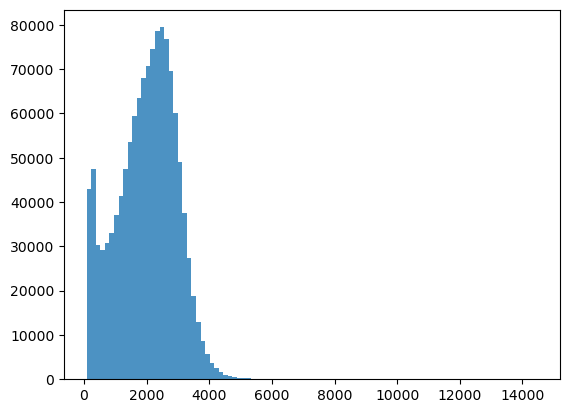

In [32]:
bins = np.linspace(min(predictors['h']),max(predictors['h']),100)
plt.hist((predictors['h']),bins,alpha=0.8);

In [33]:
predictors_sel = predictors.loc[(predictors['h'] < 7000)  ].sample(100000)
predictors_sel.insert ( 4, 'hm' ,  predictors_sel['h']/100 ) # add a col of heigh in meters
print(len(predictors_sel))
predictors_sel.head(10)

100000


,ID,X,Y,h,hm,BLDFIE_WeigAver,CECSOL_WeigAver,CHELSA_bio18,CHELSA_bio4,convergence,cti,devmagnitude,eastness,elev,forestheight,glad_ard_SVVI_max,glad_ard_SVVI_med,glad_ard_SVVI_min,northness,ORCDRC_WeigAver,outlet_dist_dw_basin,SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover
961179,961180,9.002606,49.943409,2465.75,24.6575,1539,11,2155,6596,28.451353,8080519,-1.591041,0.012319,136.325638,23,197.725586,73.151123,-44.627197,-0.011508,11,676770,19.525021,507.603088,67
607407,607408,7.765293,49.055771,4167.25,41.6725,1511,12,2255,6295,5.021838,-234507088,0.448925,-0.347678,322.474548,23,265.272461,73.711914,284.419189,-0.132713,13,802419,19.144218,471.898224,97
1060827,1060828,9.243496,49.658432,2836.25,28.3625,1473,17,2037,6471,11.806961,-147331216,0.390530,-0.012995,333.737427,23,134.083252,-75.755859,-242.521484,0.266221,16,716151,19.785627,481.739197,85
505090,505091,7.475499,49.068415,2653.00,26.5300,1511,8,2166,6255,38.529949,-50486000,0.003305,-0.023136,314.744080,17,459.085693,301.673584,186.497559,0.043207,14,895256,18.659155,456.794464,85
947348,947349,8.967719,49.036863,808.25,8.0825,1498,13,2498,6344,5.752874,-66689488,2.359247,0.025695,375.326569,18,221.609863,281.337646,458.820557,0.004314,8,821422,15.615726,456.941162,100
284850,284851,6.950663,49.603572,2410.00,24.1000,1474,10,2314,6048,-8.189173,-55867544,0.677808,-0.074596,409.441467,27,-128.700195,-172.768433,-316.594971,0.065228,16,798737,19.914400,458.479218,87
73897,73898,6.321339,49.869593,3767.00,37.6700,1476,13,1967,5935,-7.913002,-285684928,0.967748,-0.207497,364.737061,12,-94.073242,-252.760498,-336.036133,-0.039154,12,733607,19.857212,435.631836,85
1028632,1028633,9.159638,49.929903,2326.00,23.2600,1529,10,2043,6607,-4.634257,-138848160,-1.210037,-0.002230,167.123718,23,-158.086914,-169.591553,-282.893066,-0.050350,9,679557,18.590162,487.501373,85
1015487,1015488,9.126585,49.064275,1791.00,17.9100,1524,16,2229,6630,2.336048,-266147184,-0.465296,0.103106,226.628021,25,13.549561,12.242188,115.139282,0.191798,6,785819,20.237875,517.275818,86
447599,447600,7.325191,48.819760,911.25,9.1125,1508,14,2278,6233,39.398834,-65135856,-1.375481,0.071432,250.326370,26,-12.904297,99.083008,400.517822,0.159547,14,837665,18.448267,469.035736,4


In [34]:
predictors_sel.shape

(100000, 24)

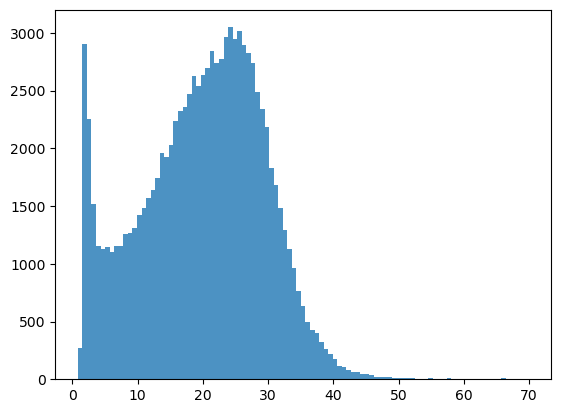

In [35]:
bins = np.linspace(min(predictors_sel['hm']),max(predictors_sel['hm']),100)
plt.hist((predictors_sel['hm']),bins,alpha=0.8);

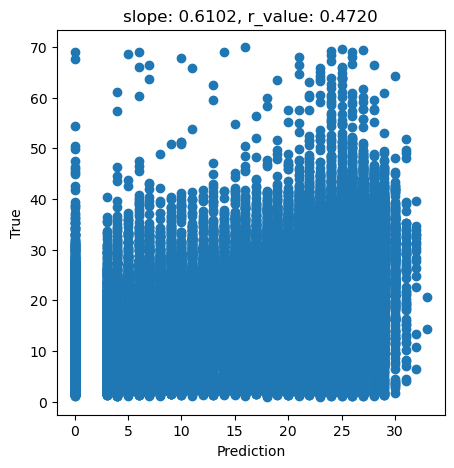

In [36]:
# What we are trying to beat
y_true = predictors_sel['hm']
y_pred = predictors_sel['forestheight']

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_true)

fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.scatter(y_pred, y_true)
ax.set_xlabel('Prediction')
ax.set_ylabel('True')
ax.set_title('slope: {:.4f}, r_value: {:.4f}'.format(slope, r_value))
plt.show()

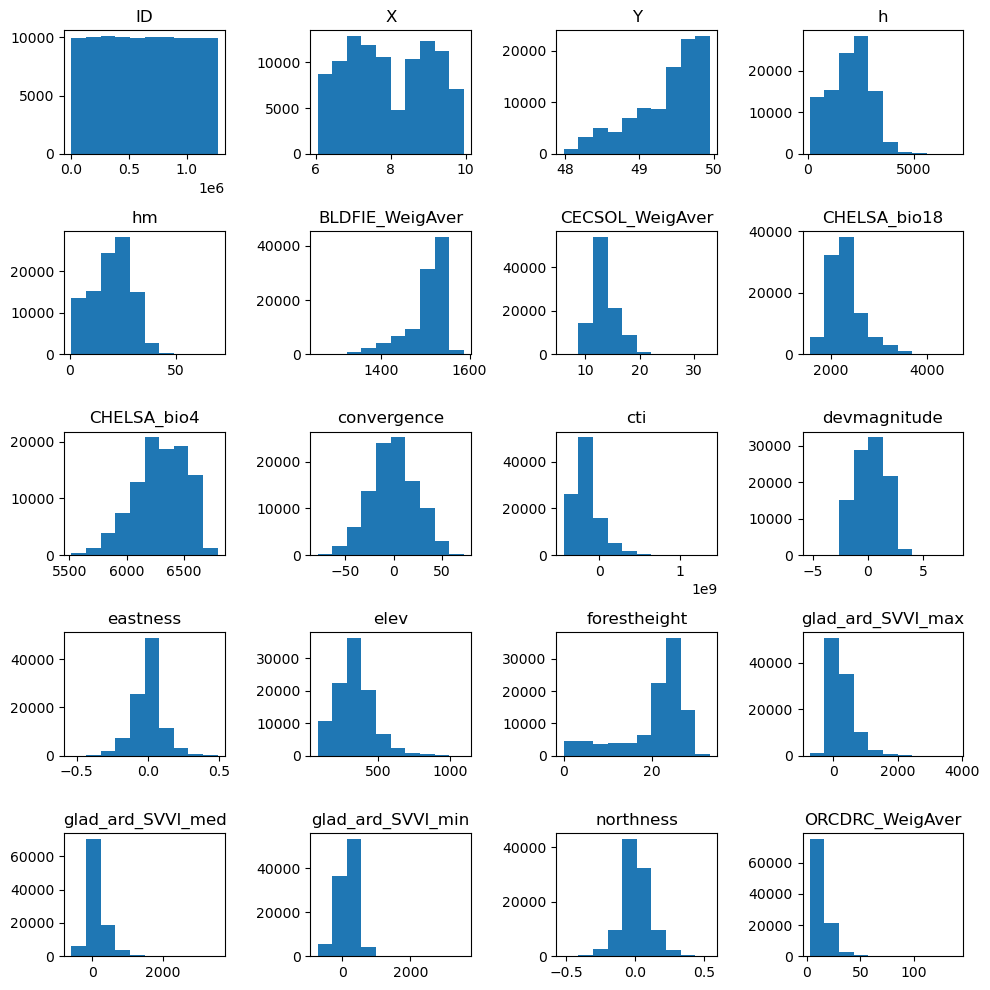

In [38]:
#Explore the raw data
# data = data.to_numpy()
n_plots_x = int(np.ceil(np.sqrt(predictors_sel.shape[1])))
n_plots_y = int(np.floor(np.sqrt(predictors_sel.shape[1])))
fig, ax = plt.subplots(n_plots_x, n_plots_y, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
ax=ax.ravel()
for idx in range(20):
    ax[idx].hist(predictors_sel.iloc[:, idx].to_numpy().flatten())
    ax[idx].set_title(predictors_sel.columns[idx])
fig.tight_layout()

In [39]:
tree_height = predictors_sel['hm'].to_numpy()
data = predictors_sel.drop(columns=['ID','h','X','Y', 'hm','forestheight'], axis=1)

Now we will split the data into training vs test datasets and perform the normalization.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(data.to_numpy()[:20000,:],tree_height[:20000], random_state=0)
print('X_train.shape:{}, X_test.shape:{} '.format(X_train.shape, X_test.shape))
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape:(15000, 18), X_test.shape:(5000, 18) 


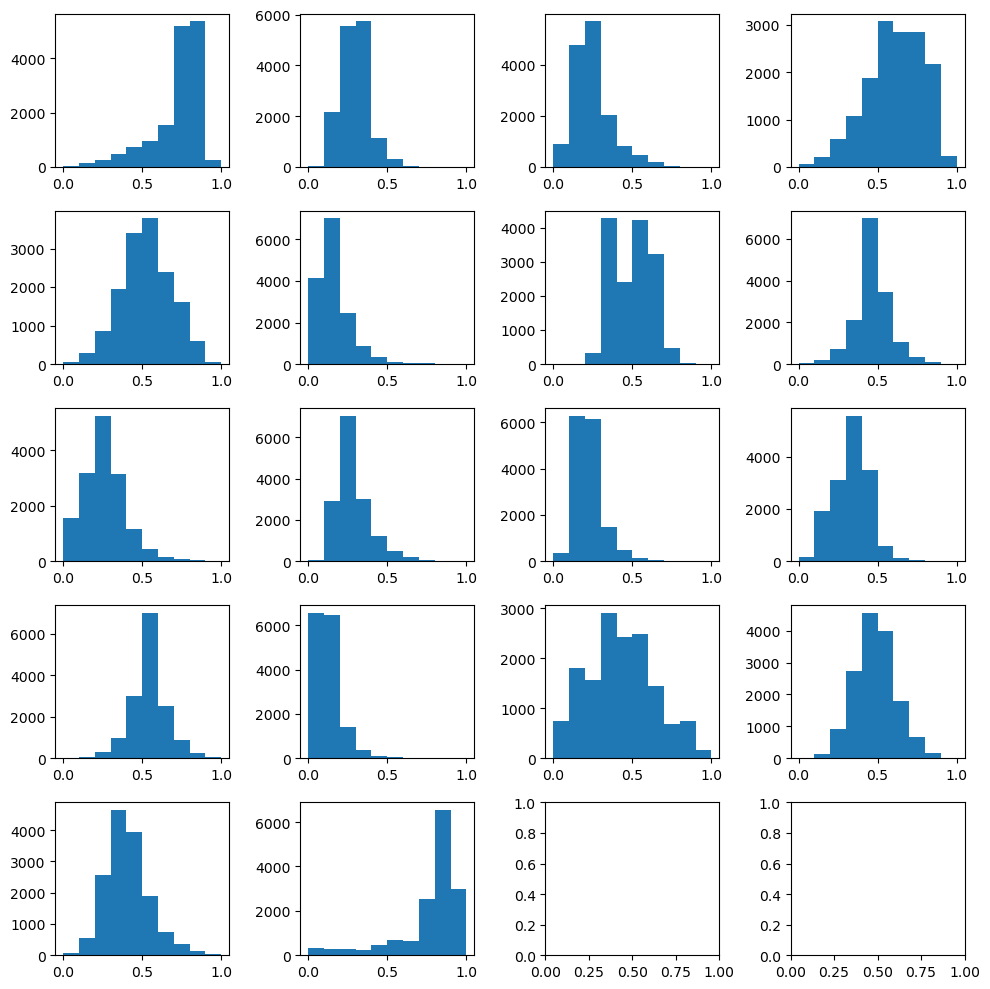

In [45]:
# Check the normalized data
n_plots_x = int(np.ceil(np.sqrt(X_train.shape[1])))
n_plots_y = int(np.floor(np.sqrt(X_train.shape[1])))
fig, ax = plt.subplots(n_plots_x, n_plots_y, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
ax=ax.ravel()
for idx in range(18):
    ax[idx].hist(X_train[:, idx].flatten())
    # ax[idx].set_title(predictors_sel.columns[idx])
fig.tight_layout()

Now, we will build our SVR regressor. For more details on all the parameters it accepts, please check the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

In [46]:
svr = SVR()
svr.fit(X_train, y_train) # Fit the SVR model according to the given training data.
print('Accuracy of SVR on training set: {:.5f}'.format(svr.score(X_train, y_train))) # Returns the coefficient of determination (R^2) of the prediction.
print('Accuracy of SVR on test set: {:.5f}'.format(svr.score(X_test, y_test)))

Accuracy of SVR on training set: 0.22928
Accuracy of SVR on test set: 0.23923


Now, let's test the fitted model

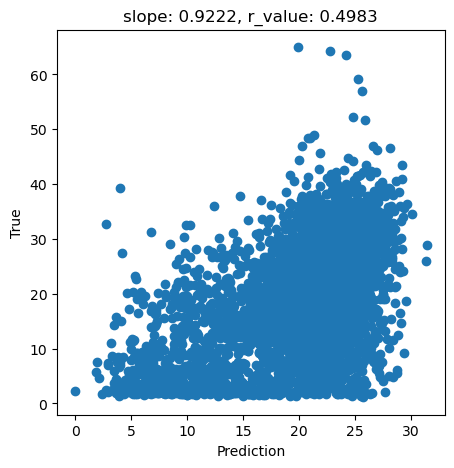

In [47]:
y_pred = svr.predict(X_test)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_test)

fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.scatter(y_pred, y_test)
ax.set_xlabel('Prediction')
ax.set_ylabel('True')
ax.set_title('slope: {:.4f}, r_value: {:.4f}'.format(slope, r_value))
plt.show()

In [48]:
svr = SVR(epsilon=0.01) # Let's change the size of the epsilon-tube
svr.fit(X_train, y_train) # Fit the SVR model according to the given training data.
print('Accuracy of SVR on training set: {:.5f}'.format(svr.score(X_train, y_train))) # Returns the coefficient of determination (R^2) of the prediction.
print('Accuracy of SVR on test set: {:.5f}'.format(svr.score(X_test, y_test)))

Accuracy of SVR on training set: 0.22953
Accuracy of SVR on test set: 0.23946


In [49]:
svr = SVR(epsilon=0.01, C=2.0) # Let's add some slack to this model
svr.fit(X_train, y_train) # Fit the SVR model according to the given training data.
print('Accuracy of SVR on training set: {:.5f}'.format(svr.score(X_train, y_train))) # Returns the coefficient of determination (R^2) of the prediction.
print('Accuracy of SVR on test set: {:.5f}'.format(svr.score(X_test, y_test)))

Accuracy of SVR on training set: 0.23885
Accuracy of SVR on test set: 0.24332


Let's do I quick plot to show how this model is performing 

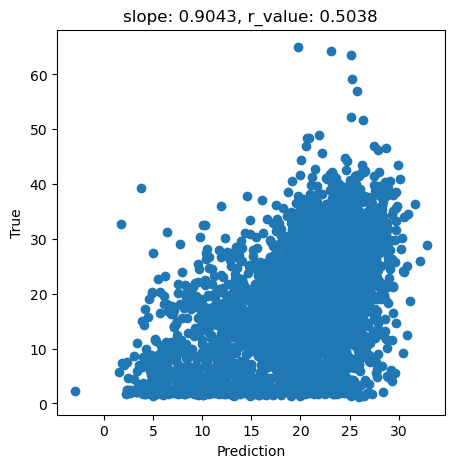

In [50]:
y_pred = svr.predict(X_test)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_test)

fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.scatter(y_pred, y_test)
ax.set_xlabel('Prediction')
ax.set_ylabel('True')
ax.set_title('slope: {:.4f}, r_value: {:.4f}'.format(slope, r_value))
plt.show()

Since 'C' and 'epsilon' are hyperparameter, how can see be sure we are selecting the best parameters for this task? 
One way is via testing a large range of parameters

C: 0.1, epsilon: 0.01, score: 0.21682555763895772
C: 0.5, epsilon: 0.01, score: 0.2327115111641429
C: 2, epsilon: 0.01, score: 0.24332399129084126
C: 5, epsilon: 0.01, score: 0.24965731432940108
C: 10, epsilon: 0.01, score: 0.2528470744558974
C: 20, epsilon: 0.01, score: 0.25391837707102427
C: 30, epsilon: 0.01, score: 0.25460988042878185
C: 0.1, epsilon: 0.1, score: 0.2170176388311188
C: 0.5, epsilon: 0.1, score: 0.23291222203744189
C: 2, epsilon: 0.1, score: 0.24341506839148852
C: 5, epsilon: 0.1, score: 0.24987982376967
C: 10, epsilon: 0.1, score: 0.25292791988873964
C: 20, epsilon: 0.1, score: 0.25441157655982005
C: 30, epsilon: 0.1, score: 0.25484581132546236
C: 0.1, epsilon: 1, score: 0.2172350627203331
C: 0.5, epsilon: 1, score: 0.23458151280777473
C: 2, epsilon: 1, score: 0.24597876827910192
C: 5, epsilon: 1, score: 0.2502379399693968
C: 10, epsilon: 1, score: 0.2534825941742753
C: 20, epsilon: 1, score: 0.2566175188714863
C: 30, epsilon: 1, score: 0.2567636969640771
C: 0.1, ep

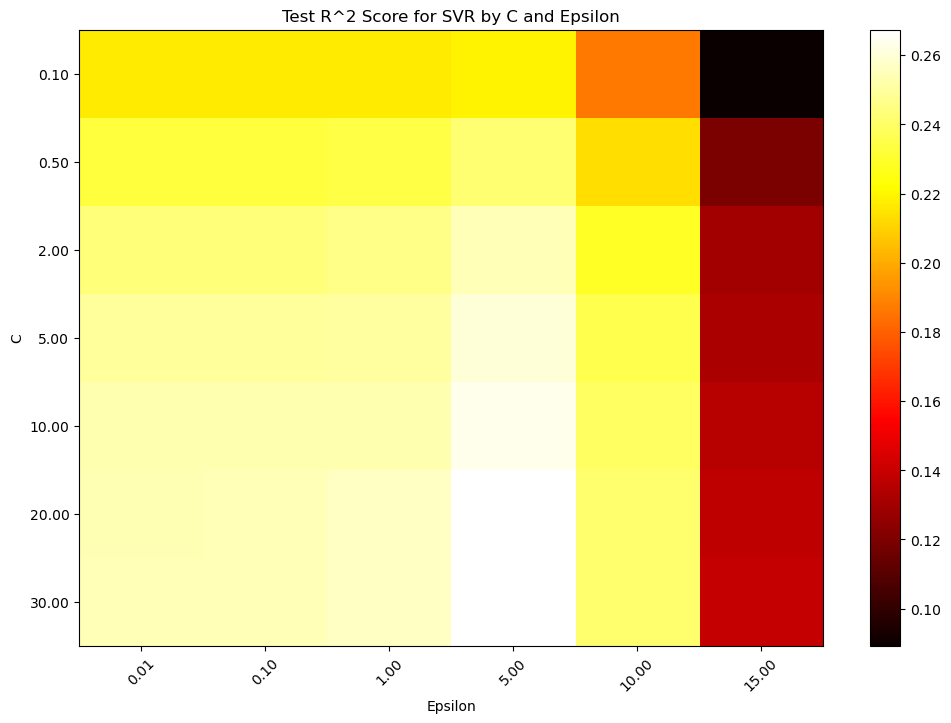

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Define a range of 'C' values and 'epsilon' values to test
C_values = [0.1, 0.5, 2, 5, 10, 20, 30]  # Logarithmically spaced values from 0.01 to 100
epsilon_values = [0.01, 0.1, 1, 5, 10, 15]  # Linearly spaced values from 0.01 to 0.1

# Matrix to store scores for each combination of C and epsilon
scores = np.zeros((len(C_values), len(epsilon_values)))

# Loop over the values of C and epsilon
for j, epsilon in enumerate(epsilon_values):
    for i, C in enumerate(C_values):
        svr = SVR(epsilon=epsilon, C=C)
        svr.fit(X_train, y_train)
        
        # Evaluate on the test set
        score = svr.score(X_test, y_test)
        scores[i, j] = score
        print(f'C: {C}, epsilon: {epsilon}, score: {score}')

# Plotting the results using a heatmap
plt.figure(figsize=(12, 8))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot, aspect='auto')
plt.xlabel('Epsilon')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(epsilon_values)), ['{:.2f}'.format(eps) for eps in epsilon_values], rotation=45)
plt.yticks(np.arange(len(C_values)), ['{:.2f}'.format(c) for c in C_values])
plt.title('Test R^2 Score for SVR by C and Epsilon')
plt.show()

For a fixed error margin (epsilon), you can perform gridsearch

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score
# Define your model without setting the C parameter
svr = SVR(epsilon=5)

# Define the parameter grid: list of dictionaries with the parameters you want to test
param_grid = {
    'C': [0.1, 0.5, 1, 2, 5, 10, 15, 20, 25, 30, 35, 40]  # Example values for C
}

# Define the scorer, if you want to change the default scoring method (which is R^2 for regression models)
scorer = make_scorer(r2_score)

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, scoring=scorer, cv=5, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best model
best_svr = grid_search.best_estimator_

# Output the best parameter
print('Best value of C:', grid_search.best_params_['C'])
print('Best cross-validated R^2 of the best estimator:', grid_search.best_score_)

# Evaluate the best model on the training set
print('Accuracy of SVR on training set: {:.5f}'.format(best_svr.score(X_train, y_train)))

# Evaluate the best model on the test set
print('Accuracy of SVR on test set: {:.5f}'.format(best_svr.score(X_test, y_test)))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best value of C: 25
Best cross-validated R^2 of the best estimator: 0.24210840688100385
Accuracy of SVR on training set: 0.29231
Accuracy of SVR on test set: 0.26717


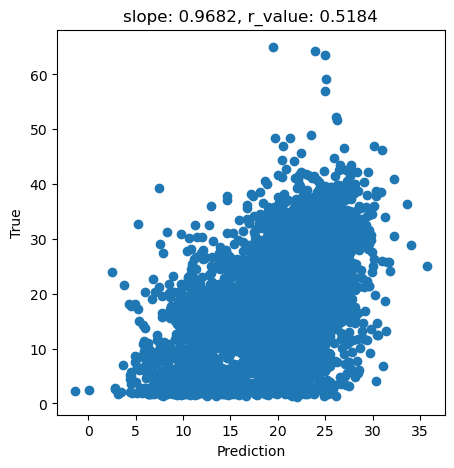

In [53]:
y_pred = best_svr.predict(X_test)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_pred, y_test)

fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.scatter(y_pred, y_test)
ax.set_xlabel('Prediction')
ax.set_ylabel('True')
ax.set_title('slope: {:.4f}, r_value: {:.4f}'.format(slope, r_value))
plt.show()

In [54]:
svr = SVR(kernel='linear',epsilon=5, C=30)
svr.fit(X_train, y_train) # Fit the SVR model according to the given training data.
print('Accuracy of SVR on training set: {:.5f}'.format(svr.score(X_train, y_train))) # Returns the coefficient of determination (R^2) of the prediction.
print('Accuracy of SVR on test set: {:.5f}'.format(svr.score(X_test, y_test)))

Accuracy of SVR on training set: 0.18720
Accuracy of SVR on test set: 0.20898


In [55]:
svr = SVR(kernel='linear')
svr.fit(X_train, y_train) # Fit the SVR model according to the given training data.
print('Accuracy of SVR on training set: {:.5f}'.format(svr.score(X_train, y_train))) # Returns the coefficient of determination (R^2) of the prediction.
print('Accuracy of SVR on test set: {:.5f}'.format(svr.score(X_test, y_test)))

Accuracy of SVR on training set: 0.17729
Accuracy of SVR on test set: 0.20066


In [20]:
# import satalite indeces
glad_ard_SVVI_min = "./tree_height_2/geodata_raster/glad_ard_SVVI_min.tif"
glad_ard_SVVI_med = "./tree_height_2/geodata_raster/glad_ard_SVVI_med.tif"
glad_ard_SVVI_max = "./tree_height_2/geodata_raster/glad_ard_SVVI_max.tif"

# import climate
CHELSA_bio4 = "./tree_height_2/geodata_raster/CHELSA_bio4.tif"
CHELSA_bio18 = "./tree_height_2/geodata_raster/CHELSA_bio18.tif"

# soil
BLDFIE_WeigAver = "./tree_height_2/geodata_raster/BLDFIE_WeigAver.tif"
CECSOL_WeigAver = "./tree_height_2/geodata_raster/CECSOL_WeigAver.tif"
ORCDRC_WeigAver = "./tree_height_2/geodata_raster/ORCDRC_WeigAver.tif"

# Geomorphological
elev = "./tree_height_2/geodata_raster/elev.tif"
convergence = "./tree_height_2/geodata_raster/convergence.tif"
northness = "./tree_height_2/geodata_raster/northness.tif"
eastness = "./tree_height_2/geodata_raster/eastness.tif"
devmagnitude = "./tree_height_2/geodata_raster/dev-magnitude.tif"

# Hydrography
cti = "./tree_height_2/geodata_raster/cti.tif"
outlet_dist_dw_basin = "./tree_height_2/geodata_raster/outlet_dist_dw_basin.tif"

# Soil climate

SBIO3_Isothermality_5_15cm = "./tree_height_2/geodata_raster/SBIO3_Isothermality_5_15cm.tif"
SBIO4_Temperature_Seasonality_5_15cm = "./tree_height_2/geodata_raster/SBIO4_Temperature_Seasonality_5_15cm.tif"

# forest

treecover = "./tree_height_2/geodata_raster/treecover.tif"

In [21]:
predictors_rasters = [glad_ard_SVVI_min, glad_ard_SVVI_med, glad_ard_SVVI_max,
                      CHELSA_bio4,CHELSA_bio18,
                      BLDFIE_WeigAver,CECSOL_WeigAver, ORCDRC_WeigAver,
                      elev,convergence,northness,eastness,devmagnitude,cti,outlet_dist_dw_basin,
                      SBIO3_Isothermality_5_15cm,SBIO4_Temperature_Seasonality_5_15cm,treecover]
print(predictors_rasters)
stack = Raster(predictors_rasters)

['./tree_height_2/geodata_raster/glad_ard_SVVI_min.tif', './tree_height_2/geodata_raster/glad_ard_SVVI_med.tif', './tree_height_2/geodata_raster/glad_ard_SVVI_max.tif', './tree_height_2/geodata_raster/CHELSA_bio4.tif', './tree_height_2/geodata_raster/CHELSA_bio18.tif', './tree_height_2/geodata_raster/BLDFIE_WeigAver.tif', './tree_height_2/geodata_raster/CECSOL_WeigAver.tif', './tree_height_2/geodata_raster/ORCDRC_WeigAver.tif', './tree_height_2/geodata_raster/elev.tif', './tree_height_2/geodata_raster/convergence.tif', './tree_height_2/geodata_raster/northness.tif', './tree_height_2/geodata_raster/eastness.tif', './tree_height_2/geodata_raster/dev-magnitude.tif', './tree_height_2/geodata_raster/cti.tif', './tree_height_2/geodata_raster/outlet_dist_dw_basin.tif', './tree_height_2/geodata_raster/SBIO3_Isothermality_5_15cm.tif', './tree_height_2/geodata_raster/SBIO4_Temperature_Seasonality_5_15cm.tif', './tree_height_2/geodata_raster/treecover.tif']


In [22]:
result = stack.predict(estimator=svr, dtype='int16', nodata=-1)

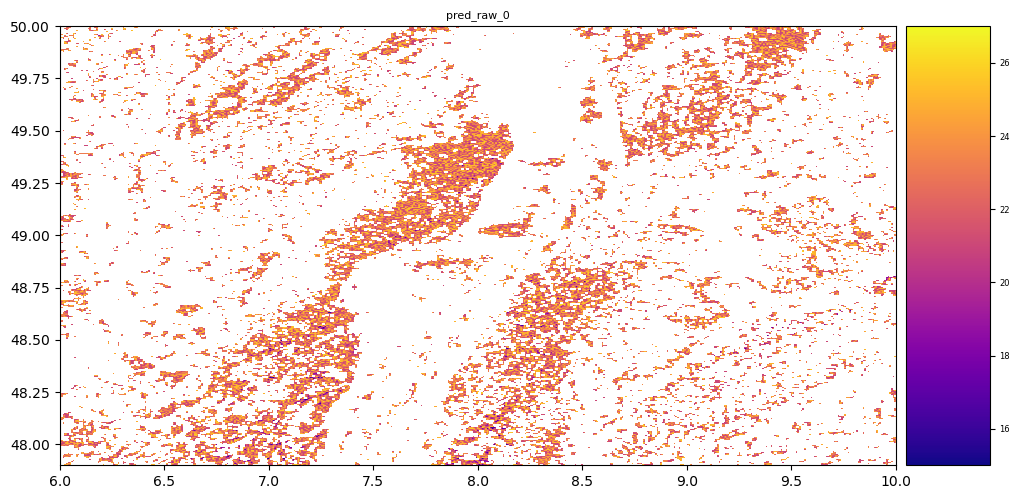

In [23]:
# plot regression result
plt.rcParams["figure.figsize"] = (12,12)
result.iloc[0].cmap = "plasma"
result.plot()
plt.show()

## Exercise: explore the other parameters offered by the SVM library and try to make the model better. Some suggestions:
- Better cleaning of the data (follow Peppe's suggestions)
- Stronger regularization might be helpful
- Play with different kernels

<span style="color:red">**For the brave ones**</span>, try to implenent the SVR algorithm from scratch. As we saw in class, the algorithm is quite simple. Here is a simple sketch of the SVM algorithm. Make the appropriate modifications to turn it into a regression. Let us know if your implementation is better than sklearn's. 

In [24]:
## Support Vector Machine 
import numpy as np

train_f1 = x_train[:,0]
train_f2 = x_train[:,1]

train_f1 = train_f1.reshape(90,1)
train_f2 = train_f2.reshape(90,1)Let's see a quick example of how to use Suppor Vector Regression for tree height estimation

w1 = np.zeros((90,1))
w2 = np.zeros((90,1))

epochs = 1
alpha = 0.0001

while(epochs < 10000):
    y = w1 * train_f1 + w2 * train_f2
    prod = y * y_train
    print(epochs)
    count = 0
    for val in prod:
        if(val >= 1):
            cost = 0
            w1 = w1 - alpha * (2 * 1/epochs * w1)
            w2 = w2 - alpha * (2 * 1/epochs * w2)
            
        else:
            cost = 1 - val 
            w1 = w1 + alpha * (train_f1[count] * y_train[count] - 2 * 1/epochs * w1)
            w2 = w2 + alpha * (train_f2[count] * y_train[count] - 2 * 1/epochs * w2)
        count += 1
    epochs += 1

NameError: name 'x_train' is not defined